# Time Series Forecasting for Future Sales
---
**Submitted by: Sheetal Bongale | March 2021**

Steps -
1. Data Wrangling and Exploratory Data Analysis
2. Feature Engineering and Selection
3. **Modeling and forecasting**
4. **Model evaluation and validation**
5. **Sales quantity forecast results and visualization**
6. Final results and analysis report

In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
from pandas import DataFrame
from pandas import Series
from pandas import concat
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.api as smt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

pio.renderers
pio.renderers.default='notebook+jupyterlab'
plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/top_selling_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2289 entries, 0 to 2288
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    2289 non-null   int64  
 1   StockCode    2289 non-null   object 
 2   Description  2289 non-null   object 
 3   Quantity     2289 non-null   int64  
 4   InvoiceDate  2289 non-null   object 
 5   UnitPrice    2289 non-null   float64
 6   CustomerID   2289 non-null   float64
 7   Country      2289 non-null   object 
 8   Year         2289 non-null   int64  
 9   Quarter      2289 non-null   int64  
 10  Month        2289 non-null   int64  
 11  Week         2289 non-null   int64  
 12  Day          2289 non-null   int64  
 13  Weekday      2289 non-null   int64  
 14  Date         2289 non-null   object 
 15  Total_Sales  2289 non-null   float64
dtypes: float64(3), int64(8), object(5)
memory usage: 286.2+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

## EDA

In [4]:
# Duration of dataset
def sales_duration(data):
    data.Date = pd.to_datetime(data.Date)
    number_of_days = data.Date.max() - data.Date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(df)

373 days
1.021917808219178 years


In [5]:
df_sales = df.groupby(['Date'])['Quantity'].sum().reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='teal', label='Total Sales')
    
    second = data.groupby(data.Date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.Date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(365)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()


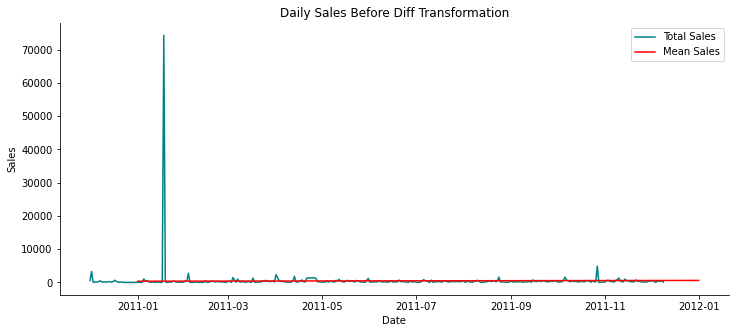

In [7]:
time_plot(df_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

## Item 1: MEDIUM CERAMIC TOP STORAGE JAR

In [8]:
df1 = df.loc[df['Description']=='MEDIUM CERAMIC TOP STORAGE JAR']

In [9]:
df1_sales = df1.groupby(['Date'])['Quantity'].sum().reset_index()
df1_sales['Date'] = pd.to_datetime(df1_sales['Date'])

In [10]:
output = adfuller(df1_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -1528.78 and p-value: 0.00000


In [11]:
d=1
series_date = df1_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -7.27 and p-value: 0.00000


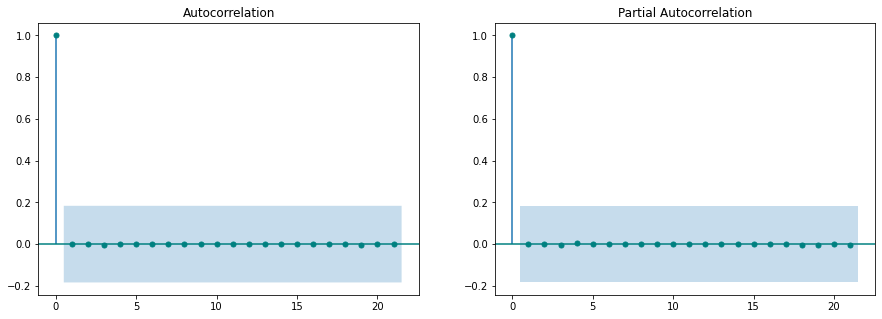

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

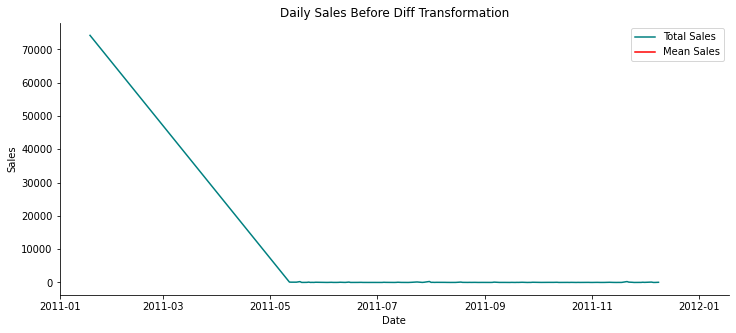

In [13]:
time_plot(df1_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

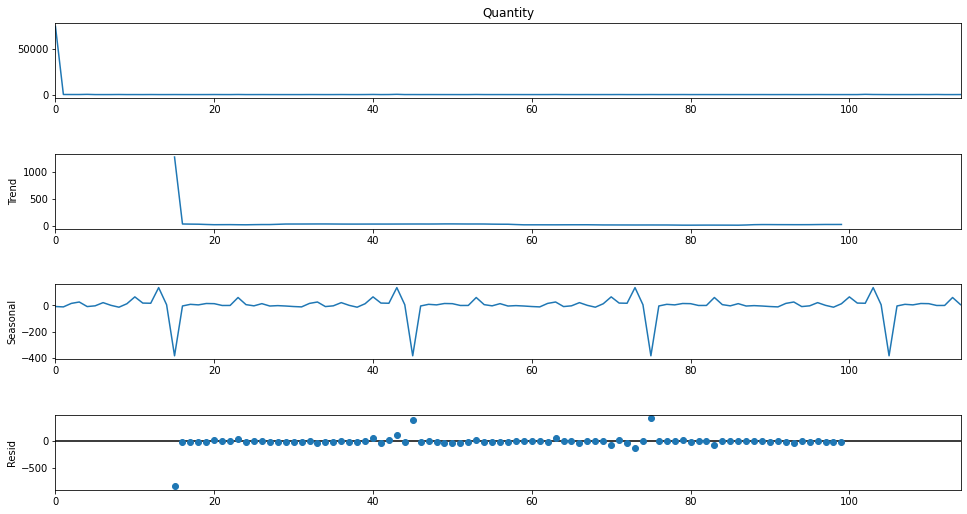

In [48]:
res = sm.tsa.seasonal_decompose(df1_sales.Quantity.dropna(),freq=30)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### 1.1 ARIMA - ITEM 1

In [16]:
series_date_1 = df1_sales.Quantity
split_time = 80
time_d = np.arange(len(df1_sales))
xtrain_d = series_date_1[:split_time]
xtest_d = series_date_1[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [17]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                   79
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -824.849
Method:                       css-mle   S.D. of innovations           8284.911
Date:                Wed, 17 Mar 2021   AIC                           1655.699
Time:                        05:56:21   BIC                           1662.807
Sample:                             1   HQIC                          1658.546
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -943.0349   1304.833     -0.723      0.470   -3500.461    1614.392
ar.L1.D.Quantity     0.0071      0.983      0.007      0.994      -1.919       1.933
                            

RMSE Train : 980.377168980422
RMSE Test : 970.9349535682958


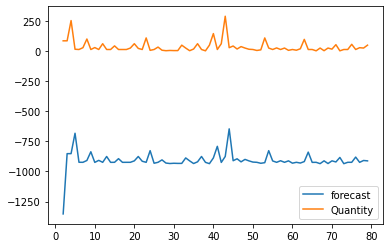

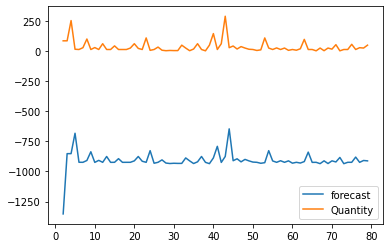

In [18]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [19]:
arima_model_fit.forecast(30)[0]

array([  -888.19251488,  -1831.17898632,  -2774.21352921,  -3717.24841223,
        -4660.28329765,  -5603.3181831 ,  -6546.35306854,  -7489.38795399,
        -8432.42283943,  -9375.45772487, -10318.49261032, -11261.52749576,
       -12204.56238121, -13147.59726665, -14090.6321521 , -15033.66703754,
       -15976.70192298, -16919.73680843, -17862.77169387, -18805.80657932,
       -19748.84146476, -20691.87635021, -21634.91123565, -22577.9461211 ,
       -23520.98100654, -24464.01589198, -25407.05077743, -26350.08566287,
       -27293.12054832, -28236.15543376])

### 1.2 SARIMA - ITEM 1

In [14]:
model=sm.tsa.statespace.SARIMAX(df1_sales['Quantity'],order=(1, 1, 0),seasonal_order=(1,1,0,12))
results=model.fit()

<AxesSubplot:>

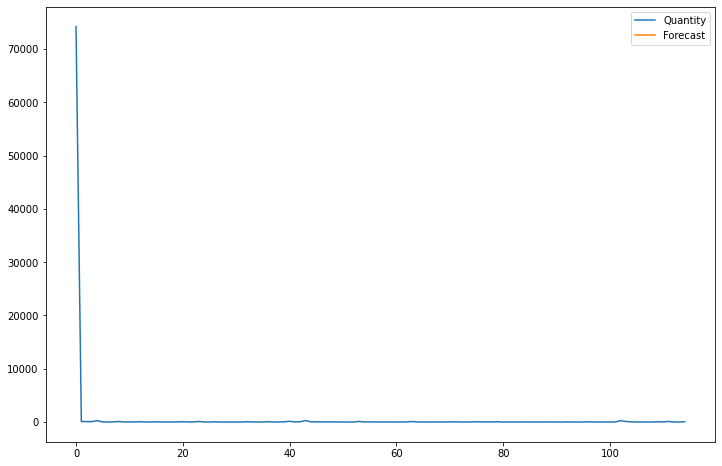

In [15]:
df1_sales['Forecast']=results.predict(start=190,end=250,dynamic=True)
df1_sales[['Quantity','Forecast']].plot(figsize=(12,8))

## Item 2: WORLD WAR 2 GLIDERS ASSTD DESIGNS

In [21]:
df2 = df.loc[df['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS']
df2_sales = df2.groupby(['Date'])['Quantity'].sum().reset_index()

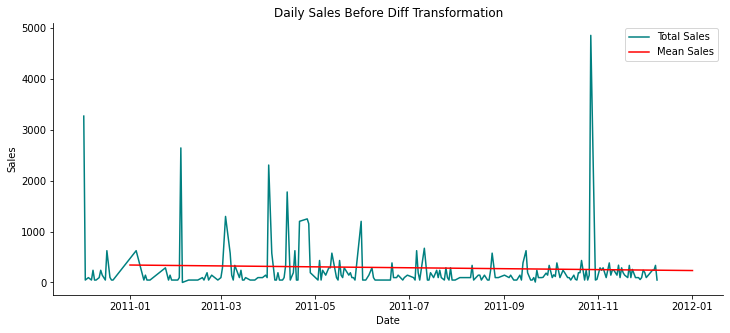

In [22]:
time_plot(df2_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

In [23]:
output = adfuller(df2_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -16.28 and p-value: 0.00000


In [24]:
d=1
series_date = df2_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -7.92 and p-value: 0.00000


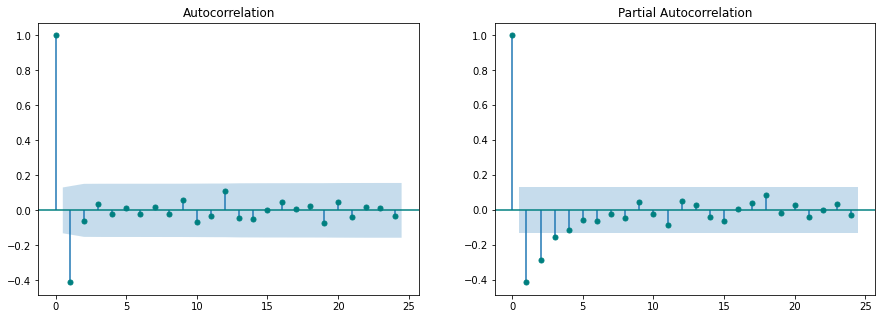

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

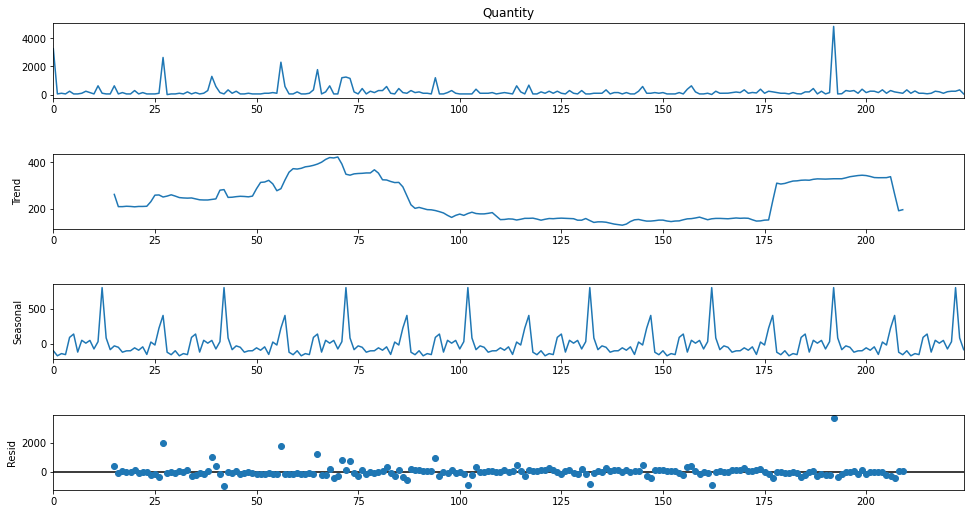

In [43]:
res = sm.tsa.seasonal_decompose(df2_sales.Quantity.dropna(),freq=30)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [29]:
series_date_2 = df2_sales.Quantity
split_time = 200
time_d = np.arange(len(df2_sales))
xtrain_d = series_date_2[:split_time]
xtest_d = series_date_2[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print(timeTrain_d)
print(timeTest_d)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224]


In [30]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  199
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1563.825
Method:                       css-mle   S.D. of innovations            625.711
Date:                Wed, 17 Mar 2021   AIC                           3133.650
Time:                        05:56:22   BIC                           3143.530
Sample:                             1   HQIC                          3137.649
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -9.8951     30.488     -0.325      0.746     -69.651      49.861
ar.L1.D.Quantity    -0.4573      0.067     -6.794      0.000      -0.589      -0.325
                            

RMSE Train : 631.9566993096558
RMSE Test : 216.53486782635323


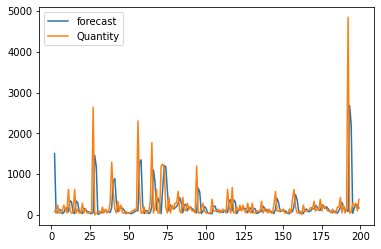

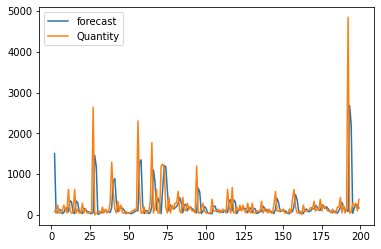

In [31]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [32]:
arima_model_fit.forecast(30)[0]

array([237.87489426, 290.27898279, 251.89394059, 255.0275591 ,
       239.17433223, 232.00395523, 220.86283531, 211.53757073,
       201.38189968, 191.60598075, 181.65639786, 171.78623301,
       161.87974961, 151.98987499, 142.09240503, 132.19840849,
       122.30282352, 112.40796496, 102.5127742 ,  92.61773536,
        82.72262704,  72.8275505 ,  62.93245943,  53.037375  ,
        43.14228753,  33.24720145,  23.35211474,  13.45702832,
         3.56194176,  -6.33314473])

<AxesSubplot:>

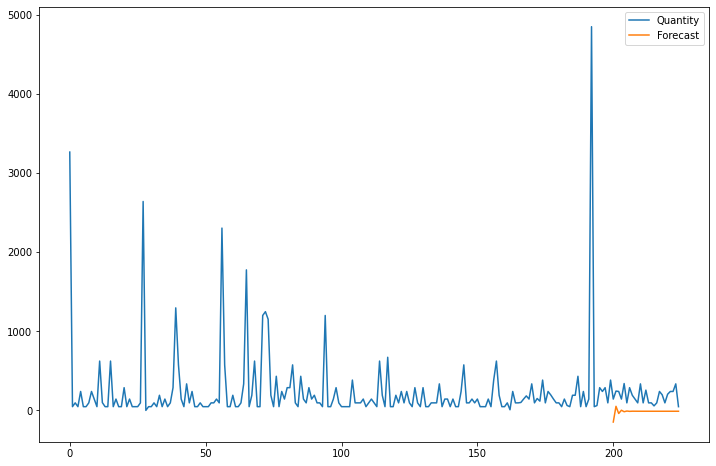

In [33]:
df2_sales['Forecast']=arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)
df2_sales[['Quantity','Forecast']].plot(figsize=(12,8))

### 2.2 SARIMA - ITEM 2

In [26]:
model=sm.tsa.statespace.SARIMAX(df2_sales['Quantity'],order=(1, 1, 0),seasonal_order=(1,1,0,12))
results=model.fit()

<AxesSubplot:>

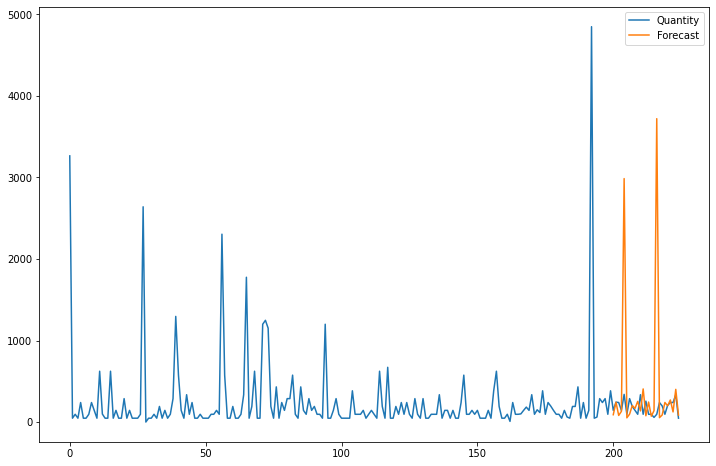

In [27]:
df2_sales['Forecast']=results.predict(start=200,end=224,dynamic=True)
df2_sales[['Quantity','Forecast']].plot(figsize=(12,8))

In [28]:
df2_sales.tail(20)

,Date,Quantity,Forecast
205,2011-11-15,96,52.553494
206,2011-11-16,288,97.669632
207,2011-11-17,192,203.693255
208,2011-11-18,144,168.420793
209,2011-11-20,96,254.190004
210,2011-11-21,336,137.480484
211,2011-11-22,96,406.667397
212,2011-11-23,257,77.717191
213,2011-11-25,96,245.807038
214,2011-11-27,96,72.405501


### 2.1 ARIMA - ITEM 2

## Item 3: JUMBO BAG RED RETROSPOT

In [34]:
df3 = df.loc[df['Description']=='JUMBO BAG RED RETROSPOT']
df3_sales = df3.groupby(['Date'])['Quantity'].sum().reset_index()

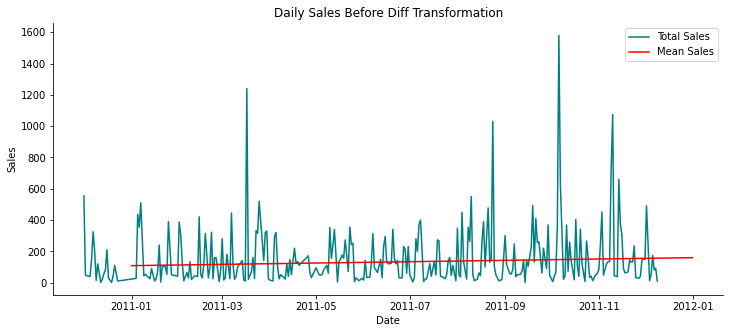

In [35]:
time_plot(df3_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

In [36]:
output = adfuller(df3_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -12.23 and p-value: 0.00000


In [37]:
d=1
series_date = df3_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -10.25 and p-value: 0.00000


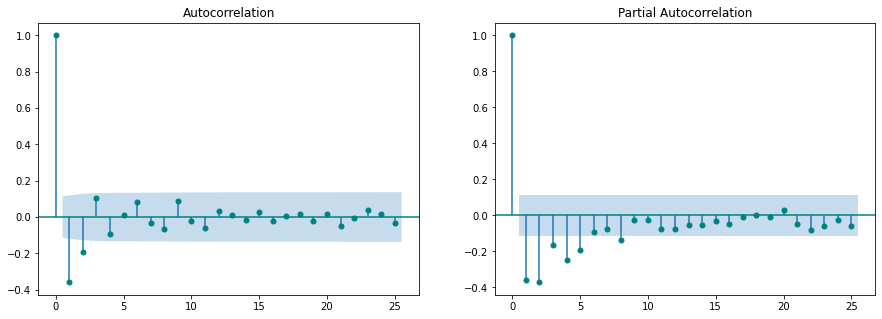

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

In [39]:
resDiff = sm.tsa.arma_order_select_ic(df3_sales['Quantity'], max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (1, 1) is the best.


### 3.1 ARIMA - Item 3

In [44]:
series_date_3=df3_sales.Quantity
split_time = 250
time_d=np.arange(len(df3_sales))
xtrain_d=series_date_3[:split_time]
xtest_d=series_date_3[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [45]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  249
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1699.134
Method:                       css-mle   S.D. of innovations            222.418
Date:                Wed, 17 Mar 2021   AIC                           3404.268
Time:                        05:59:02   BIC                           3414.820
Sample:                             1   HQIC                          3408.515
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4703     10.138     -0.046      0.963     -20.340      19.399
ar.L1.D.Quantity    -0.3920      0.059     -6.635      0.000      -0.508      -0.276
                            

RMSE Train : 264.6740458079438
RMSE Test : 274.73765391516315


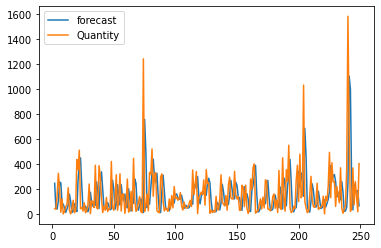

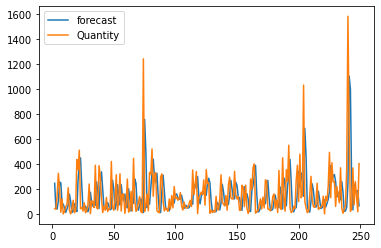

In [46]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=250,end=350,dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [47]:
df3_sales['Forecast'] = ytest_pred

### 3.2 SARIMA - ITEM 3

In [40]:
model=sm.tsa.statespace.SARIMAX(df3_sales['Quantity'],order=(3, 1, 0),seasonal_order=(3,1,0,12))
results=model.fit()

<AxesSubplot:>

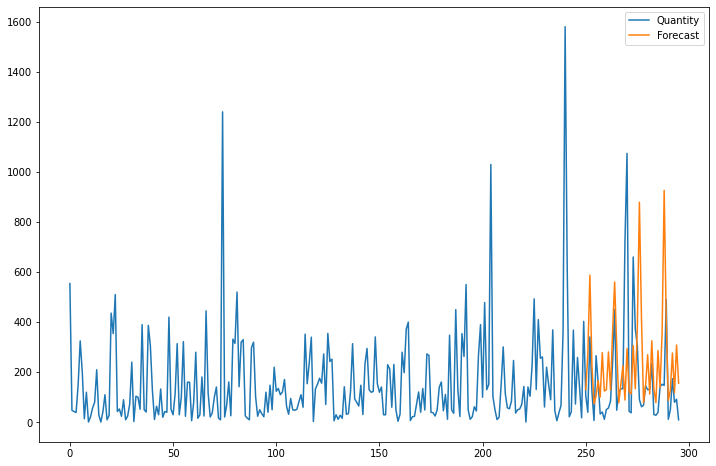

In [41]:
df3_sales['Forecast']=results.predict(start=250,end=350,dynamic=True)
df3_sales[['Quantity','Forecast']].plot(figsize=(12,8))

In [42]:
df3_sales.tail(15)

,Date,Quantity,Forecast
281,2011-11-23,132,112.447558
282,2011-11-24,235,325.429583
283,2011-11-25,31,134.555589
284,2011-11-27,28,78.237329
285,2011-11-28,39,286.230142
286,2011-11-29,141,139.237176
287,2011-11-30,152,355.846711
288,2011-12-01,147,926.246421
289,2011-12-02,490,406.723123
290,2011-12-04,12,86.883111
